### Importing moduls 

In [1]:
import pandas as pd
import re
import numpy as np
from gensim.models import FastText

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Preprocessing  

In [3]:
# Funtion For Load and preprocess chat data

def parse_chat(file_path):
    pattern = re.compile(
        r"^(\d{1,2}[\/\.-]\d{1,2}[\/\.-]\d{2,4}),? (\d{1,2}:\d{2}(?:\s?[APMapm]{2})?) - ([^:]+): (.*)"
    )
    data = []
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()

    for line in lines:
        match = pattern.match(line.strip())
        if match:
            date, time, contact, message = match.groups()
            data.append([date, time, contact, message])

    df = pd.DataFrame(data, columns=["date", "time", "contact", "message"])
    df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
    return df

In [4]:
df = parse_chat(
    r"C:\Users\HP\Documents\Projects\whatsApp_chat_analysis\WhatsApp Chat with CSDS Official Group 2022-26.txt"
)
df = df[df["message"] != "<Media omitted>"]

In [5]:
df

,date,time,contact,message
1,2023-08-18,9:15 am,Vijayalaxmi Ma'am GITA,Students follow this updated time table
6,2023-08-24,10:18 am,Vijayalaxmi Ma'am GITA,Try to clear your dues ASAP
7,2023-08-24,11:52 pm,Vijayalaxmi Ma'am GITA,*Seventh edition of India Mobile Congress (IMC...
8,2023-08-25,1:18 pm,Vijayalaxmi Ma'am GITA,"On request by some of the students, ur registr..."
9,2023-08-25,8:35 pm,Vijayalaxmi Ma'am GITA,*Important: Smart India Hackathon 2023 Awarene...
...,...,...,...,...
753,2025-04-05,10:24 am,NK kamila Sir GITA,Format of project reports is as follows:
754,2025-04-05,10:24 am,NK kamila Sir GITA,Subsequent pages are your detail project work.
759,2025-04-07,12:41 pm,NK kamila Sir GITA,Those who are having internal back in the subj...
760,2025-04-08,8:12 am,Tarini Pattnaik Sir OS,Tata Social Enterprise Challenge 2025 is back ...


In [6]:
# Sentiment Analysis

analyzer = SentimentIntensityAnalyzer()
def get_sentiment_vader(text):
    if not isinstance(text, str) or text.strip() == "":
        return "neutral"
    score = analyzer.polarity_scores(text)["compound"]
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

In [7]:
df["sentiment"] = df["message"].apply(get_sentiment_vader)

In [8]:
# Stopword Removal 

def preprocess_text(text):
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return words

In [9]:
df["processed_message"] = df["message"].apply(preprocess_text)

In [10]:
df

,date,time,contact,message,sentiment,processed_message
1,2023-08-18,9:15 am,Vijayalaxmi Ma'am GITA,Students follow this updated time table,neutral,"[students, follow, updated, time, table]"
6,2023-08-24,10:18 am,Vijayalaxmi Ma'am GITA,Try to clear your dues ASAP,positive,"[try, clear, dues, asap]"
7,2023-08-24,11:52 pm,Vijayalaxmi Ma'am GITA,*Seventh edition of India Mobile Congress (IMC...,positive,"[seventh, edition, india, mobile, congress, im..."
8,2023-08-25,1:18 pm,Vijayalaxmi Ma'am GITA,"On request by some of the students, ur registr...",negative,"[request, students, ur, registration, dead, li..."
9,2023-08-25,8:35 pm,Vijayalaxmi Ma'am GITA,*Important: Smart India Hackathon 2023 Awarene...,positive,"[important, smart, india, hackathon, 2023, awa..."
...,...,...,...,...,...,...
753,2025-04-05,10:24 am,NK kamila Sir GITA,Format of project reports is as follows:,neutral,"[format, project, reports, follows]"
754,2025-04-05,10:24 am,NK kamila Sir GITA,Subsequent pages are your detail project work.,neutral,"[subsequent, pages, detail, project, work]"
759,2025-04-07,12:41 pm,NK kamila Sir GITA,Those who are having internal back in the subj...,positive,"[internal, back, subject, ai, 5th, semester, i..."
760,2025-04-08,8:12 am,Tarini Pattnaik Sir OS,Tata Social Enterprise Challenge 2025 is back ...,positive,"[tata, social, enterprise, challenge, 2025, ba..."


In [11]:
# Label Encoding
le = LabelEncoder()
df["sentiment_level"] = le.fit_transform(df["sentiment"])

In [12]:
# FastText Embedding
fasttext_model = FastText(
    sentences=df["processed_message"], vector_size=100, window=5, min_count=1, workers=4
)

In [13]:
# Vector Formation 

def get_sentence_vector(words, model, vector_size):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)


In [14]:
df["vector"] = df["processed_message"].apply(
    lambda x: get_sentence_vector(x, fasttext_model, 100)
)

In [15]:
X = np.array(df["vector"].tolist())
y = np.array(df["sentiment_level"])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Use Random Forest 

In [17]:
# Improved RandomForest with GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [18]:
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest Accuracy: 0.7647058823529411


In [19]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.76      0.90      0.82        39
           2       0.75      0.62      0.68        24

    accuracy                           0.76        68
   macro avg       0.84      0.64      0.69        68
weighted avg       0.77      0.76      0.75        68



### Use ANN(DL)

In [20]:
model_ann = Sequential([
    Dense(128, input_shape=(100,), activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
optimizer = Adam(learning_rate=0.00005)
model_ann.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [23]:
model_ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,147 (86.51 KB)

 Trainable params: 21,763 (85.01 KB)

 Non-trainable params: 384 (1.50 KB)

In [25]:
history_ann = model_ann.fit(X_train, y_train, epochs=90,batch_size=32,validation_split=0.2)

Epoch 1/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.4249 - loss: 1.2450 - val_accuracy: 0.6909 - val_loss: 1.0969
Epoch 2/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5026 - loss: 1.0469 - val_accuracy: 0.6909 - val_loss: 1.0955
Epoch 3/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4182 - loss: 1.2043 - val_accuracy: 0.6909 - val_loss: 1.0939
Epoch 4/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4636 - loss: 1.0565 - val_accuracy: 0.6909 - val_loss: 1.0924
Epoch 5/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4688 - loss: 1.1187 - val_accuracy: 0.6909 - val_loss: 1.0906
Epoch 6/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4969 - loss: 1.0148 - val_accuracy: 0.6909 - val_loss: 1.0891
Epoch 7/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5463 - loss: 1.0366 - val_accuracy: 0.6909 - val_loss: 1.0875
Epoch 8/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6080 - loss: 0.9189 - val_accuracy: 0.6909 - val_loss: 1.0858


In [31]:
# loss_ann, acc_ann = model_ann.evaluate(X_test, y_test)
# print(f"ANN Test Accuracy: {acc_ann:.4f}")


In [32]:
# y_pred_ann = np.argmax(model_ann.predict(X_test), axis=-1)
# print(classification_report(y_test, y_pred_ann))

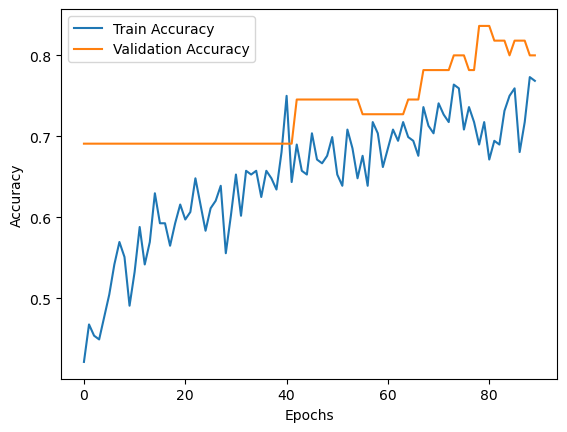

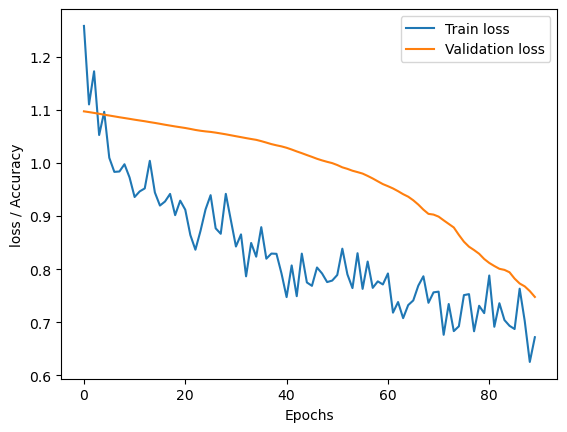

In [28]:
# Plotting performance

plt.plot(history_ann.history['accuracy'], label='Train Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_ann.history['loss'], label='Train loss')
plt.plot(history_ann.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss / Accuracy')
plt.legend()
plt.show()

## Data Analysis 

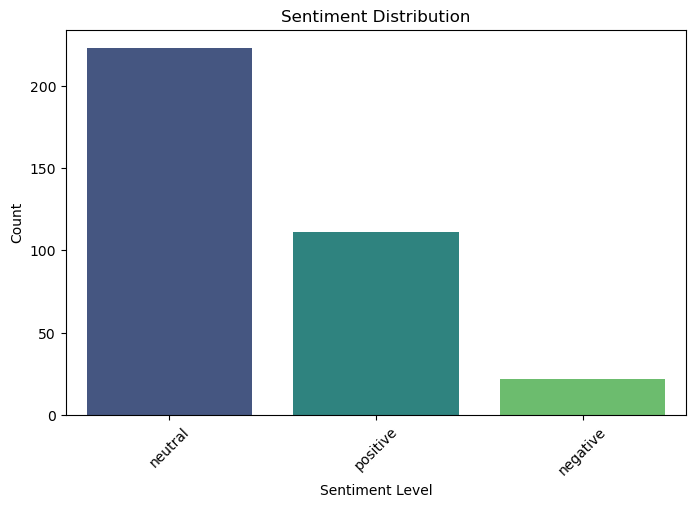

In [15]:
def plot_sentiment_distribution(df):
    """Plots the distribution of sentiment levels in the dataset."""
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df['sentiment'], palette='viridis')
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment Level")
    plt.ylabel("Count")
    plt.xticks(rotation=45)  # Rotate labels if needed
    plt.show()

# Call the function
plot_sentiment_distribution(df)

In [16]:
df

,date,time,contact,message,sentiment,processed_message,sentiment_level,vector
1,2023-08-18,9:15 am,Vijayalaxmi Ma'am GITA,Students follow this updated time table,neutral,"[students, follow, updated, time, table]",1,"[-0.00077080016, -0.00046254462, -0.0011772502..."
6,2023-08-24,10:18 am,Vijayalaxmi Ma'am GITA,Try to clear your dues ASAP,positive,"[try, clear, dues, asap]",2,"[-0.00016958266, -0.0001440687, 0.00039321955,..."
7,2023-08-24,11:52 pm,Vijayalaxmi Ma'am GITA,*Seventh edition of India Mobile Congress (IMC...,positive,"[seventh, edition, india, mobile, congress, im...",2,"[-0.00034224102, 0.0013424788, -0.0009685879, ..."
8,2023-08-25,1:18 pm,Vijayalaxmi Ma'am GITA,"On request by some of the students, ur registr...",negative,"[request, students, ur, registration, dead, li...",0,"[-0.00045751303, 0.0010362273, -0.001617069, -..."
9,2023-08-25,8:35 pm,Vijayalaxmi Ma'am GITA,*Important: Smart India Hackathon 2023 Awarene...,positive,"[important, smart, india, hackathon, 2023, awa...",2,"[-0.00044145362, 0.00087107834, -0.0007741839,..."
...,...,...,...,...,...,...,...,...
753,2025-04-05,10:24 am,NK kamila Sir GITA,Format of project reports is as follows:,neutral,"[format, project, reports, follows]",1,"[-0.0005839022, 3.815908e-05, -0.0007135604, 0..."
754,2025-04-05,10:24 am,NK kamila Sir GITA,Subsequent pages are your detail project work.,neutral,"[subsequent, pages, detail, project, work]",1,"[-0.0010678733, 0.0005300024, -0.0013281635, -..."
759,2025-04-07,12:41 pm,NK kamila Sir GITA,Those who are having internal back in the subj...,positive,"[internal, back, subject, ai, 5th, semester, i...",2,"[-0.00042223866, 0.00031886413, -0.0008850024,..."
760,2025-04-08,8:12 am,Tarini Pattnaik Sir OS,Tata Social Enterprise Challenge 2025 is back ...,positive,"[tata, social, enterprise, challenge, 2025, ba...",2,"[-8.466344e-05, 0.0009096432, -0.0009319237, -..."


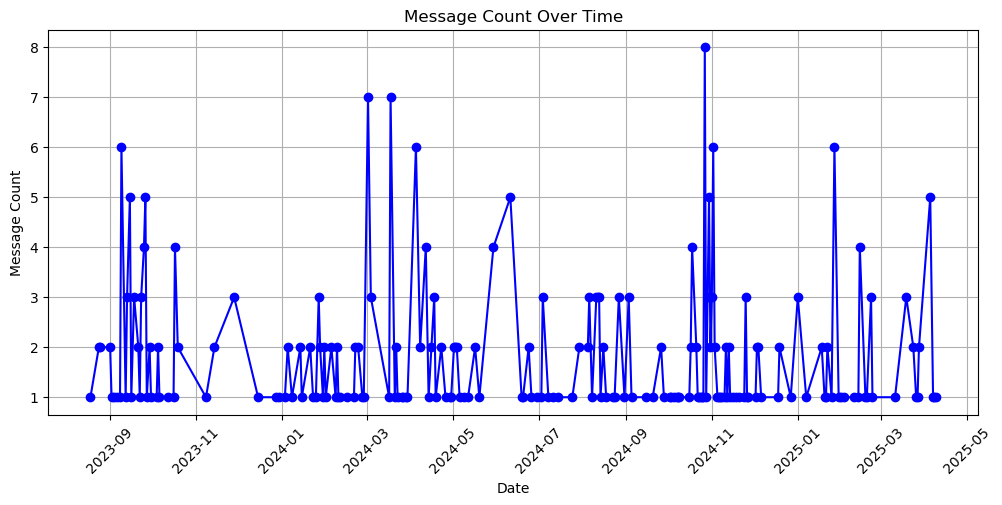

In [17]:
### 2. Message Count Over Time
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.date  # Extract date without time
message_count = df.groupby('day').size()

plt.figure(figsize=(12, 5))
plt.plot(message_count, marker='o', linestyle='-', color='b')
plt.title("Message Count Over Time")
plt.xlabel("Date")
plt.ylabel("Message Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

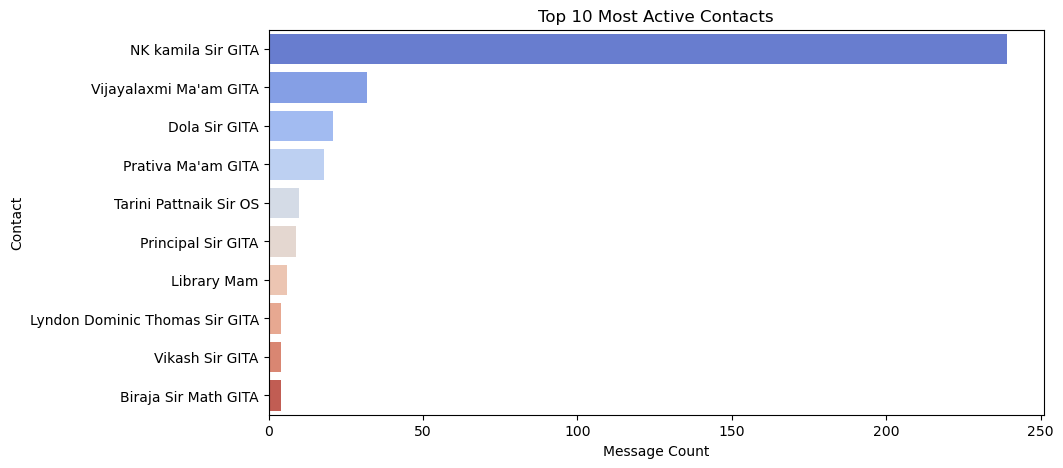

In [18]:
top_contacts = df['contact'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(y=top_contacts.index, x=top_contacts.values, palette="coolwarm")
plt.title("Top 10 Most Active Contacts")
plt.xlabel("Message Count")
plt.ylabel("Contact")
plt.show()

<Figure size 1200x500 with 0 Axes>

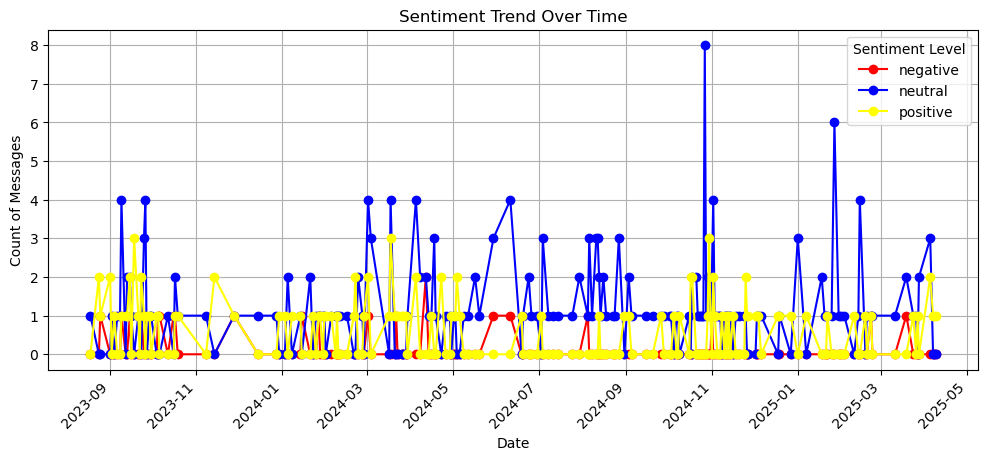

In [19]:
### 4. Sentiment Trends Over Time
sentiment_trend = df.groupby(['date', 'sentiment']).size().unstack().fillna(0)

plt.figure(figsize=(12, 5))
sentiment_trend.plot(kind="line", marker="o",color=['red', 'blue', 'yellow'] , figsize=(12, 5))
plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Count of Messages")
plt.xticks(rotation=45)
plt.legend(title="Sentiment Level")
plt.grid(True)
plt.show()

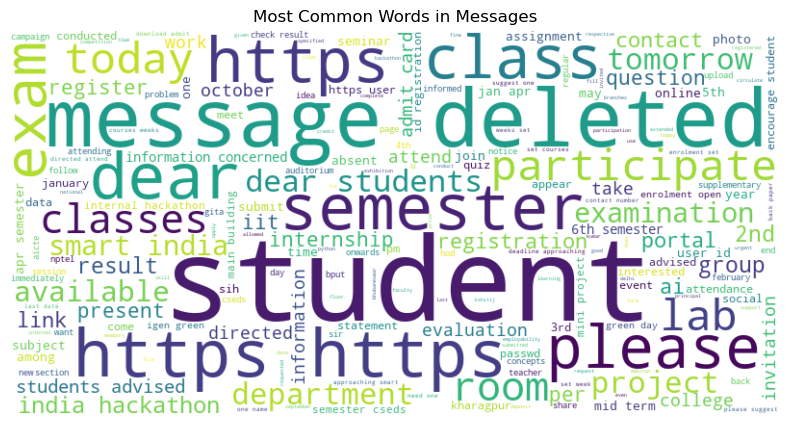

In [20]:
### 5. Word Cloud (Most Common Words)
all_words = ' '.join([' '.join(msg) for msg in df['processed_message']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Messages")
plt.show()